In [231]:
from urllib.request import urlopen
from xmltodict import parse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import Normalizer

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D
from keras.optimizers import Adam, Adamax, RMSprop, SGD

import keras.backend as K

In [232]:
def QueryECB(series):
    raw1 = urlopen("https://sdw-wsrest.ecb.europa.eu/service/data/EXR/" + series + ".SP00.A")
    raw2 = raw1.read().decode('utf8')
    raw3 = parse(raw2)
    raw4 = raw3['message:GenericData']['message:DataSet']['generic:Series']['generic:Obs']
    res = {x['generic:ObsDimension']['@value']: 
           float(x['generic:ObsValue']['@value'])
           for x in raw4}
    return res

In [233]:
cad = QueryECB("D.CAD.EUR")
usd = QueryECB("D.USD.EUR")

In [234]:
df = pd.DataFrame({'CAD/EUR': [x for x in cad.values()], 
                   'USD/EUR': [x for x in usd.values()]}, 
                  [x for x in usd.keys()])
df.head(10)

,CAD/EUR,USD/EUR
1999-01-04,1.8004,1.1789
1999-01-05,1.7965,1.1790
1999-01-06,1.7711,1.1743
1999-01-07,1.7602,1.1632
1999-01-08,1.7643,1.1659
1999-01-11,1.7463,1.1569
1999-01-12,1.7392,1.1520
1999-01-13,1.8123,1.1744
1999-01-14,1.7707,1.1653
1999-01-15,1.7797,1.1626


In [235]:
df.iloc[:,1] = df.iloc[:,1].shift(1)

In [236]:
df = df.dropna()

sc = Normalizer()
df_sc = sc.fit_transform(df)

train = df_sc[:4500,]
test = df_sc[4500:4860,]

x_train = train[:,0]
y_train = train[:,1]
x_test = test[:,0]
y_test = test[:,1]

In [237]:
K.clear_session()

model = Sequential()

model.add(Dense(30, input_shape=(1,), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dropout(0.05))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.01))
model.add(Dense(1, activation='relu'))

model.compile(optimizer=Adamax(lr=0.004), loss='mean_absolute_error')
model.fit(x_train, y_train, batch_size=5, epochs=20, verbose=1)

Epoch 1/20
4500/4500 [==============================] - 2s 447us/step - loss: 0.0848
Epoch 2/20
4500/4500 [==============================] - 2s 382us/step - loss: 0.0285
Epoch 3/20
4500/4500 [==============================] - 2s 433us/step - loss: 0.0161
Epoch 4/20
4500/4500 [==============================] - 2s 437us/step - loss: 0.0137
Epoch 5/20
4500/4500 [==============================] - 2s 396us/step - loss: 0.0118
Epoch 6/20
4500/4500 [==============================] - 2s 423us/step - loss: 0.0101
Epoch 7/20
4500/4500 [==============================] - 2s 386us/step - loss: 0.0090
Epoch 8/20
4500/4500 [==============================] - 2s 371us/step - loss: 0.0080
Epoch 9/20
4500/4500 [==============================] - 2s 425us/step - loss: 0.0070
Epoch 10/20
4500/4500 [==============================] - 2s 415us/step - loss: 0.0062
Epoch 11/20
4500/4500 [==============================] - 2s 415us/step - loss: 0.0061
Epoch 12/20
4500/4500 [==============================] - 2s 400

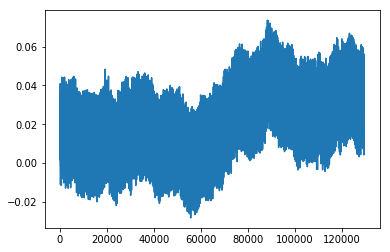

In [242]:
y_pred = model.predict(x_test)
ys = [(a-b)[0] for a in y_pred for b in y_test]
plt.plot(ys)
#plt.plot(y_test)
#plt.plot(y_pred-y_test)

In [243]:
K.clear_session()
model = Sequential()

model.add(Dense(80, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(LSTM(20,
              return_sequences=True,
              activation='tanh'))
model.add(Dense(1, activation='relu'))

model.compile(optimizer=SGD(lr=0.01), loss='mean_squared_error')
model.fit(x_train.reshape(50,90,1), y_train.reshape(50,90,1), batch_size=5, epochs=10, verbose=1)

Epoch 1/10
50/50 [==============================] - 2s 41ms/step - loss: 0.1341
Epoch 2/10
50/50 [==============================] - 1s 18ms/step - loss: 0.0106
Epoch 3/10
50/50 [==============================] - 1s 19ms/step - loss: 0.0109
Epoch 4/10
50/50 [==============================] - 1s 18ms/step - loss: 0.0111
Epoch 5/10
50/50 [==============================] - 1s 17ms/step - loss: 0.0105
Epoch 6/10
50/50 [==============================] - 1s 21ms/step - loss: 0.0107
Epoch 7/10
50/50 [==============================] - 1s 21ms/step - loss: 0.0106
Epoch 8/10
50/50 [==============================] - 1s 18ms/step - loss: 0.0103
Epoch 9/10
50/50 [==============================] - 1s 20ms/step - loss: 0.0099
Epoch 10/10
50/50 [==============================] - 1s 17ms/step - loss: 0.0099


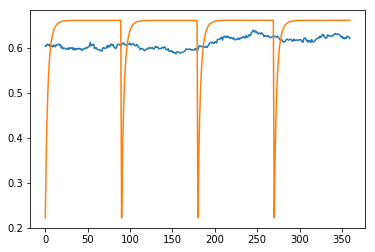

In [244]:
y_pred = model.predict(x_test.reshape(4,90,1))

plt.plot(y_test)
plt.plot(y_pred.reshape(360))